# Thoracic and Abdominal Breathing during Repetitive Tasks

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as si
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import neurokit2 as nk
from dtw import dtw, accelerated_dtw
import emd
import glob
import os

sns.set()

## Import data

In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), '/Users/luissilva/PycharmProjects/PhysioOper/data', "*.txt"))
file_list = np.sort(file_list)
print(file_list)

data = []

for file_path in file_list:
    load = np.loadtxt(file_path)
    data.append(load)

info = []

for file_path in file_list:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        info.append(lines[1][19:21])

['/Users/luissilva/PycharmProjects/PhysioOper/data/S02_REST_POS_2021-11-11_17-41-17.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_REST_PRE_2021-11-11_16-17-24.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task1_2021-11-05_15-52-46.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task2_2021-11-05_16-13-59.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S02_task3_2021-11-05_16-37-44.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_REST_POS_2021-11-11_13-06-56.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_REST_PRE_2021-11-11_11-15-07.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK1_2021-11-11_12-19-12.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK2_2021-11-11_12-35-07.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S03_TASK3_2021-11-11_12-55-04.txt'
 '/Users/luissilva/PycharmProjects/PhysioOper/data/S04_REST_POS_2021-11-11_17-41-17.txt'
 '/Users/luissilva/PycharmProjects/Phys

## Prepare data

In [3]:
id_value = 200000

for ii in range(0, len(data)):
    if len(data[ii]) > 200000:
        data[ii] = data[ii][len(data[ii]) - 570000 - 20000: -20000, :]
    else:
        data[ii] = data[ii][-120000:, :]

resp_data = []

for ii in range(0, len(data)):
    if info[ii] == 'AD':
        resp = np.array([data[ii][:, 7], data[ii][:, 8]])
        resp_data.append(resp)
    elif info[ii] == 'DC':
        resp = np.array([data[ii][:, 16], data[ii][:, 17]])
        resp_data.append(resp)

## Filter data 

In [4]:
filtered_resp = resp_data.copy()
col = resp_data[1].shape[0]

for ii in range(0, len(filtered_resp)):
    for jj in range(0, col):
        filtered_resp[ii][jj, :] = nk.signal_filter(resp_data[ii][jj, :], lowcut=0.15, highcut=.45,
                                                  method='fir', order=5)

## Downsample data

In [5]:
ds_resp = []

for ii in range(0, len(filtered_resp)):
    ds = filtered_resp[ii][:, ::25]
    ds_resp.append(ds)

In [6]:
ds_resp[1].shape

(2, 4800)

## Signal decomposition

In [7]:
comp_resp = []

for ii in range(0, len(ds_resp)):
    for jj in range(0, col):
        imf_resp = emd.sift.ensemble_sift(ds_resp[ii][jj, :], max_imfs=5)
        comp_resp.append(imf_resp)

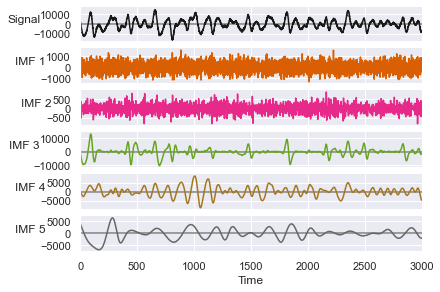

In [8]:
emd.plotting.plot_imfs(comp_resp[18][5000:8000, :], cmap=True)

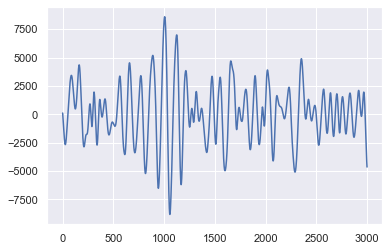

In [9]:
plt.plot(comp_resp[18][5000:8000, 3])

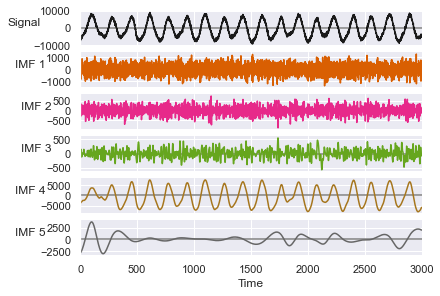

In [10]:
emd.plotting.plot_imfs(comp_resp[2][1000:4000, :], cmap=True)

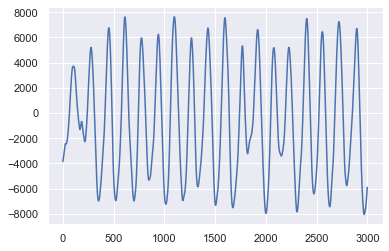

In [11]:
plt.plot(comp_resp[2][1000:4000,3])

## Normalization

In [12]:
# Signal itself

z_ds_resp = ds_resp.copy()

for ii in range(0, len(ds_resp)):
    for jj in range(0, col):
        z_ds_resp[ii][jj, :] = (ds_resp[ii][jj, :] - np.mean(ds_resp[ii][jj, :])) / np.std(ds_resp[ii][jj, :])
        
# Reconstructed signal of the decomposition

z_comp_resp = comp_resp.copy()

for ii in range(0, len(comp_resp)):
    for jj in range(0, 5):
        z_comp_resp[ii][:, jj] = (comp_resp[ii][:, jj] - np.mean(comp_resp[ii][:, jj])) / np.std(comp_resp[ii][:, jj])

In [13]:
print(len(z_ds_resp))
print(len(z_comp_resp))
print(z_ds_resp[1].shape)
print(z_comp_resp[1].shape)

20
40
(2, 4800)
(4800, 5)


# Amplitude analysis

#### Amplitude analysis comprises the difference between the maximum and the minimum amplitude. For this analysis, the signal component will be used.

In [14]:
def window_def(signal, window_size=100, step=10):
    
    signal_windowed = []

    bins = int(((len(signal) - window_size) / step) + 1)
 
    for ii in range(0, bins * step, step):
        seq = signal[ii: ii + window_size]
        signal_windowed.append(seq)
    
    return signal_windowed


def smooth(y, win_size):
    window = np.ones(win_size) / win_size
    y_smooth = np.convolve(y, window, mode='same')

    return y_smooth

219
223


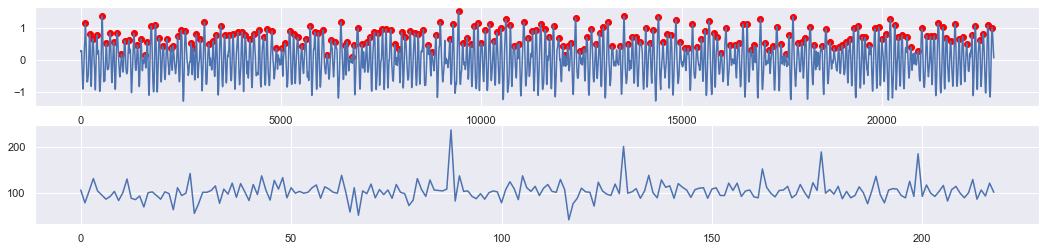

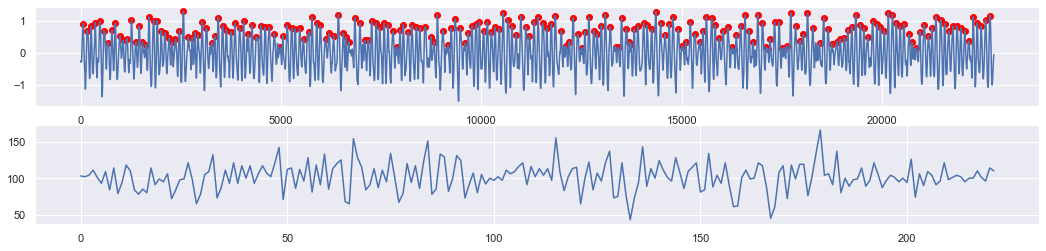

In [15]:
# Signal to look at #
h = .1
w = 30
signal = 4
s_max1 = z_comp_resp[signal][:, 3]
s_max = np.diff(s_max1[5: -5])
s_max = s_max * 10
peaks = si.find_peaks(s_max, height=0.08, width=25)
# yp = pd.Series(peaks[0])
# yp = yp.interpolate(limit_direction='both', kind='cubic')
plt.figure(figsize=[18,4])
plt.subplot(2,1,1)
plt.scatter(peaks[0], s_max[peaks[0]], color='red')
plt.plot(s_max)
plt.subplot(2,1,2)
dif_peaks = np.diff(peaks[0])
plt.plot(dif_peaks)

s_min = -s_max
valleys = si.find_peaks(s_min, height=0.08, width=25)
plt.figure(figsize=[18,4])
plt.subplot(2,1,1)
plt.scatter(valleys[0], s_min[valleys[0]], color='red')
plt.plot(s_min)
plt.subplot(2,1,2)
dif_valleys = np.diff(valleys[0])
plt.plot(dif_valleys)

print(len(peaks[0]))
print(len(valleys[0]))

In [191]:
subj = int(len(info) / 5)
mom = [ii for ii in range(len(z_comp_resp)) if ii % 5 == 4]
moms1 = np.floor(np.linspace(mom[0], mom[1], 6)).astype(int)
moms = []
moms.append(moms1)

for ii in range(0, subj-1):
    n = moms[ii]
    n = n + 10
    moms.append(n)

moms = np.array(moms)
moms = moms.reshape(moms.shape[0]*moms.shape[1])

amplitude = [] 

for signal in moms:
    
    s_max1 = z_comp_resp[signal][:, 3]
    s_max = np.diff(s_max1[5: -5])
    s_max = s_max * 10
    peaks = si.find_peaks(s_max, height=0.08, width=25)
    peaks_pd = pd.DataFrame(peaks[1]['peak_heights'])
    ws_p = int(len(peaks_pd) / 10)
    peaks_wind = window_def(peaks_pd, window_size=ws_p, step=ws_p)
    mean_peaks = np.mean(peaks_wind, axis=1)
    
    s_min = -s_max
    valleys = si.find_peaks(s_min, height=0.08, width=25)
    valleys_pd = pd.DataFrame(valleys[1]['peak_heights'])
    ws_v = int(len(valleys_pd) / 10)
    valleys_wind = window_def(valleys_pd, window_size=ws_v, step=ws_v)
    mean_valleys = np.mean(valleys_wind, axis=1)
    
    amp = mean_peaks + mean_valleys
    amplitude.append(amp)

In [17]:
amplitude = np.array(amplitude)
amplitude_df = amplitude.reshape(len(amplitude)*10)

In [18]:
sub = np.repeat(np.linspace(1,subj,subj).astype(int), 60)
body_part_v = np.repeat([1,2], 10)
body_part = np.tile(body_part_v, 12)
time = np.tile(np.linspace(1,10,10).astype(int), 24)
trial_v = np.repeat([1,2,3], 20)
trial = np.tile(trial_v, 4)

amp_df = {'Id': sub, 'Trial': trial, 'Time': time, 'Body': body_part, 'Amplitude': amplitude_df}
amp_df = pd.DataFrame(amp_df)

(1.0, 2.0)

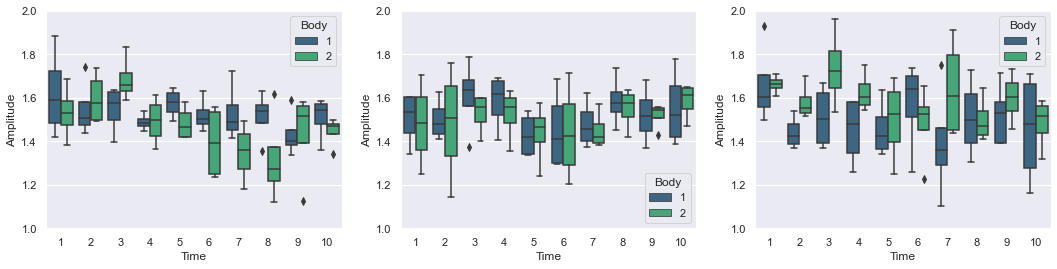

In [19]:
plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
sns.boxplot(y='Amplitude', x='Time', 
            data=amp_df[amp_df['Trial']==1], 
            palette="viridis",
            hue='Body')

plt.ylim([1,2])

plt.subplot(1,3,2)
sns.boxplot(y='Amplitude', x='Time', 
            data=amp_df[amp_df['Trial']==2], 
            palette="viridis",
                 hue='Body')
plt.ylim([1,2])

plt.subplot(1,3,3)
sns.boxplot(y='Amplitude', x='Time', 
            data=amp_df[amp_df['Trial']==3], 
            palette="viridis",
            hue='Body')
plt.ylim([1,2])

## Coherence analysis

In [230]:
coe_l = [ii for ii in range(len(moms)) if ii % 2 == 0]
coe = moms[coe_l]
coherence_f = []
coherence_Cxy = []


for signal in coe:
    f, Cxy = si.coherence(z_comp_resp[signal][:, 3], z_comp_resp[signal+1][:, 3], fs=40, nperseg=300)
    coherence_f.append(f)
    coherence_Cxy.append(Cxy)


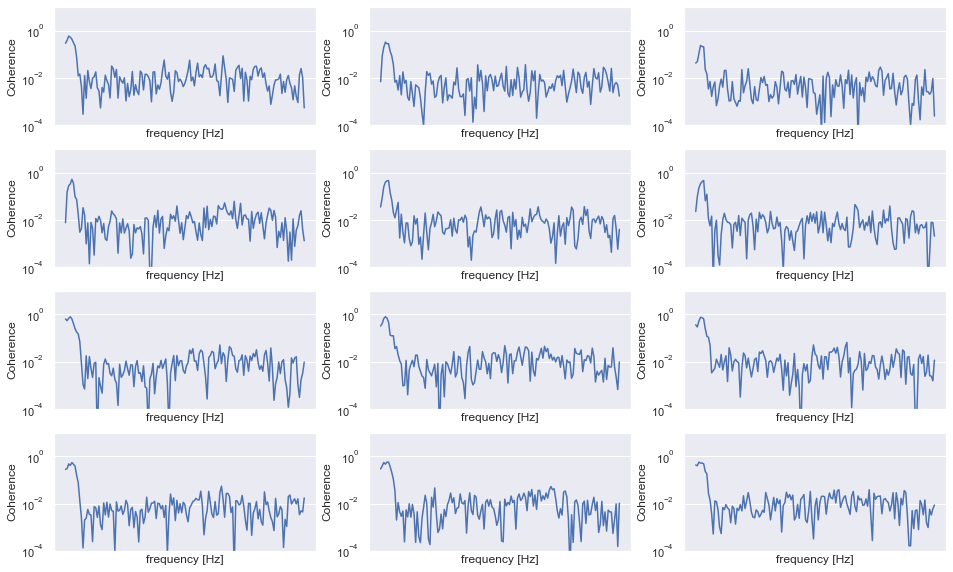

In [231]:
plt.figure(figsize=[16,10])

for signal in range(0,len(coherence_Cxy)):
    plt.subplot(4,3,signal+1)
    plt.semilogy(coherence_f[signal], coherence_Cxy[signal])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Coherence')
    plt.xticks([])
    plt.ylim([0.0001, 10])

Text(0, 0.5, 'Samples')

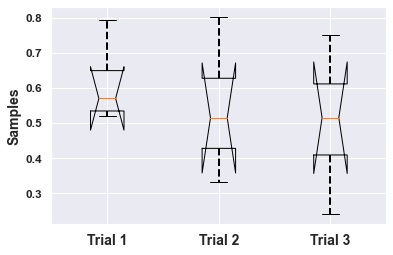

In [232]:
l_c = [ii for ii in range(0,len(coherence_Cxy)) if ii % 3 == 0]

m_coer = []

for ii in range(0,len(coherence_Cxy)):
    c_i = np.max(coherence_Cxy[ii])
    m_coer.append(c_i)           

c1 = []
c2 = []
c3 = []

for n in l_c:
    t1 = m_coer[n]
    c1.append(t1)
    t2 = m_coer[n+1]
    c2.append(t2)
    t3 = m_coer[n+2]
    c3.append(t3)

labels = ['Trial 1','Trial 2','Trial 3']
plt.boxplot([c1, c2, c3], notch=True, labels=labels, whiskerprops=dict(linestyle='--',linewidth=2.0))
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Samples', fontweight='bold', fontsize=14)

## Synchronization

#### The synchronization analysis comprises four different methods: 1) Pearson coefficient in segmented and overlapping window; 2) Cross correlation; 3) Dynamic time warping; 4) Instantaneous phase.

### Pearson coefficient with overlapping window

In [20]:
# Signal itself

cor = []
center=False

for ii in range(0, len(ds_resp)):
    s = nk.signal_synchrony(z_ds_resp[ii][0, :], z_ds_resp[ii][1, :], method="correlation", window_size=40*10)
    cor.append(s)    

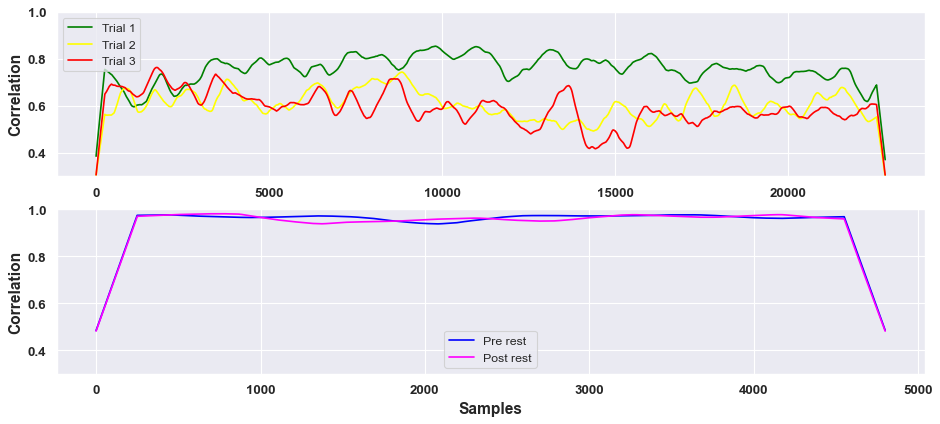

In [21]:
rest = [ii for ii in range(len(info)) if ii % 5 == 0]
tasks = [ii for ii in range(len(info)) if ii % 5 == 2]

pre_i = []
pos_i = []
green_i = []
yellow_i = []
red_i = []

for n in rest:
    pr = cor[n+1]
    po = cor[n]
    pre_i.append(pr)
    pos_i.append(po)

for n in tasks:
    g = cor[n]
    green_i.append(g)
    y = cor[n+1]
    yellow_i.append(y)
    r = cor[n+2]
    red_i.append(r)

pre = np.mean(pre_i, axis=0)
pos = np.mean(pos_i, axis=0)
    
green = np.mean(green_i, axis=0)
yellow = np.mean(yellow_i, axis=0)
red = np.mean(red_i, axis=0)

wind = 500
plt.figure(figsize=(14, 6), dpi=80)
plt.subplot(211)
plt.plot(smooth(green, wind), color='green')
plt.plot(smooth(yellow, wind), color='yellow')
plt.plot(smooth(red, wind), color='red')
plt.ylim([0.3, 1.0])
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Correlation', fontweight='bold', fontsize=14)
plt.legend(['Trial 1','Trial 2','Trial 3'])
plt.subplot(212)
plt.plot(smooth(pre, wind), color='blue')
plt.plot(smooth(pos, wind), color='magenta')
plt.ylim([0.3, 1.0])
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Samples', fontweight='bold', fontsize=14)
plt.ylabel('Correlation', fontweight='bold', fontsize=14)
plt.legend(['Pre rest','Post rest'])

In [22]:
# Reconstructed signal of the decomposition

cor_d = []
tasks_d = [ii for ii in range(len(z_comp_resp)) if ii % 2 == 0]

for n in tasks_d:
    d = nk.signal_synchrony(z_comp_resp[n][:, 3], z_comp_resp[n + 1][:, 3], method="correlation", window_size=40*10)
    cor_d.append(d) 

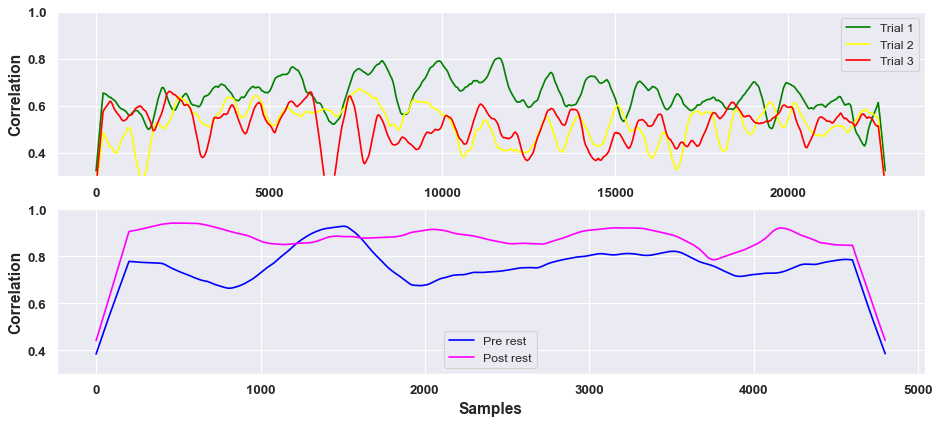

In [23]:
rest = [ii for ii in range(len(info)) if ii % 5 == 0]
tasks = [ii for ii in range(len(info)) if ii % 5 == 2]

pre_i = []
pos_i = []
green_i = []
yellow_i = []
red_i = []

for n in rest:
    pr = cor_d[n+1]
    po = cor_d[n]
    pre_i.append(pr)
    pos_i.append(po)

for n in tasks:
    g = cor_d[n]
    green_i.append(g)
    y = cor_d[n+1]
    yellow_i.append(y)
    r = cor_d[n+2]
    red_i.append(r)

pre = np.mean(pre_i, axis=0)
pos = np.mean(pos_i, axis=0)
    
green = np.mean(green_i, axis=0)
yellow = np.mean(yellow_i, axis=0)
red = np.mean(red_i, axis=0)

wind = 400
plt.figure(figsize=(14, 6), dpi=80)
plt.subplot(211)
plt.plot(smooth(green, wind), color='green')
plt.plot(smooth(yellow, wind), color='yellow')
plt.plot(smooth(red, wind), color='red')
plt.ylim([0.3, 1.0])
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Correlation', fontweight='bold', fontsize=14)
plt.legend(['Trial 1','Trial 2','Trial 3'])
plt.subplot(212)
plt.plot(smooth(pre, wind), color='blue')
plt.plot(smooth(pos, wind), color='magenta')  
plt.ylim([0.3, 1.0])
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Samples', fontweight='bold', fontsize=14)
plt.ylabel('Correlation', fontweight='bold', fontsize=14)
plt.legend(['Pre rest','Post rest'])

### Cross-correlation

In [24]:
# Signal itself

xcor = np.zeros((len(z_ds_resp), 1))
xlag = np.zeros((len(z_ds_resp), 1))

for n in range(0, len(ds_resp)):
    corr = si.correlate(z_ds_resp[n][0, :], z_ds_resp[n][1, :], mode='full', method='auto')
    lags = si.correlation_lags(len(z_ds_resp[n][0, :]), len(z_ds_resp[n][1, :]))
    corr /= np.max(corr)
    pos = np.argmax(corr)
    xcor[n] = np.max(corr)
    xlag[n] = len(corr) / 2 - pos
    
print(xlag.T)

[[  0.5  -0.5  -3.5 -16.5 -14.5   0.5   1.5   3.5   6.5   7.5   0.5  -0.5
   -1.5  -0.5   2.5  -6.5  -8.5   4.5   4.5   5.5]]


Text(0, 0.5, 'Samples')

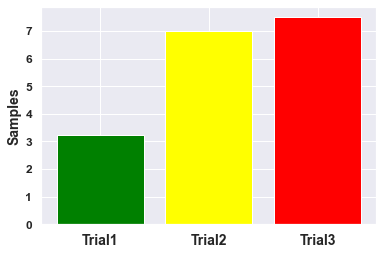

In [25]:
xlag = abs(xlag)
l_xlag = [ii for ii in range(0,len(xlag)) if ii % 5 == 2]

task1 = []
task2 = []
task3 = []

for n in l_xlag:
    t1 = xlag[n]
    task1.append(t1)
    t2 = xlag[n+1]
    task2.append(t2)
    t3 = xlag[n+2]
    task3.append(t3)

task1 = np.mean(task1)
task2 = np.mean(task2)
task3 = np.mean(task3)

plt.bar(['Trial1', 'Trial2', 'Trial3'], [task1, task2, task3], color=['green','yellow', 'red'])
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Samples', fontweight='bold', fontsize=14)

In [26]:
# Reconstructed signal of the decomposition

xcor_d = np.zeros((len(z_comp_resp), 1))
xlag_d = np.zeros((len(z_comp_resp), 1))

tasks = [ii for ii in range(len(z_comp_resp)) if ii % 2 == 0]

for n in tasks:
    corr = si.correlate(z_comp_resp[n][:, 3], z_comp_resp[n + 1][:, 3], mode='full', method='auto')
    lags = si.correlation_lags(len(z_comp_resp[n][:, 3]), len(z_comp_resp[n + 1][:, 3]))
    corr /= np.max(corr)
    pos = np.argmax(corr)
    xcor_d[n] = np.max(corr)
    xlag_d[n] = len(corr) / 2 - pos

xlag_d = xlag_d[xlag_d != 0]

In [27]:
xlag_d

array([ 5.000e-01, -5.000e-01, -3.500e+00,  8.350e+01,  8.450e+01,
        5.000e-01,  1.500e+00,  5.000e-01,  4.500e+00,  4.500e+00,
        5.000e-01, -5.000e-01, -1.500e+00, -5.000e-01,  4.500e+00,
       -6.500e+00, -5.655e+02,  6.500e+00,  4.500e+00,  4.500e+00])

Text(0, 0.5, 'Samples')

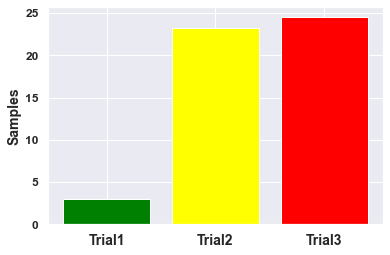

In [28]:
xlag_d = abs(xlag_d)

l_xlag_d = [ii for ii in range(0,len(xlag_d)) if ii % 5 == 2]

task1 = []
task2 = []
task3 = []

for n in l_xlag_d:
    t1 = xlag_d[n]
    task1.append(t1)
    t2 = xlag_d[n+1]
    task2.append(t2)
    t3 = xlag_d[n+2]
    task3.append(t3)

task1 = np.mean(task1)
task2 = np.mean(task2)
task3 = np.mean(task3)

plt.bar(['Trial1', 'Trial2', 'Trial3'], [task1, task2, task3], color=['green','yellow', 'red'])
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Samples', fontweight='bold', fontsize=14)


### Instantaneous phase synchrony

#### In the following two methods the signal that will be used is converted by Hilbert-Huang transform. In this case, the reconstructed signal of the decomposition must be used.

In [29]:
phase_chest = []
phase_abd = []
phase_synchrony = []

tasks2 = [ii for ii in range(len(z_comp_resp)) if ii % 2 == 0]

for n in tasks2:
    y1 = comp_resp[n][:, 3]
    ph_chest = np.angle(si.hilbert(y1),deg=False)
    phase_chest.append(ph_chest)
    y2 = comp_resp[n + 1][:, 3]
    ph_abd= np.angle(si.hilbert(y2),deg=False)
    phase_abd.append(ph_abd)

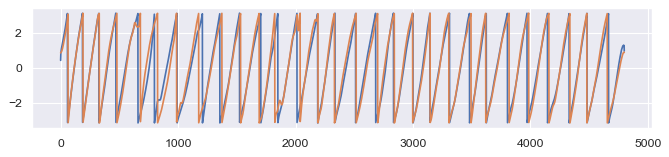

In [30]:
plt.figure(figsize=(10, 2), dpi=80)
plt.plot(phase_chest[1])
plt.plot(phase_abd[1])

In [31]:
for jj in range(0,len(phase_chest)):
    phase_diff = 1 - np.sin(np.abs(phase_chest[jj] - phase_abd[jj]) / 2)
    phase_synchrony.append(phase_diff)

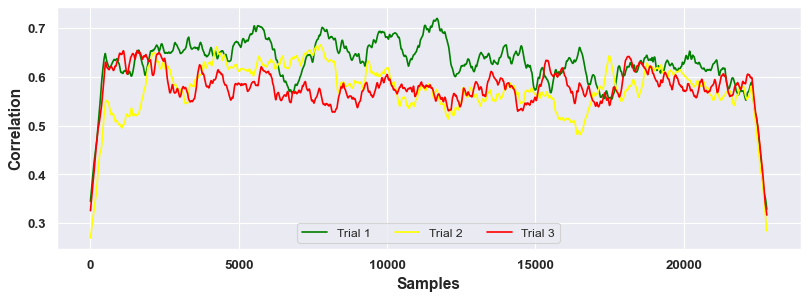

In [32]:
l_phase = [ii for ii in range(0,len(phase_synchrony)) if ii % 5 == 2]

ph1 = []
ph2 = []
ph3 = []

for n in l_phase:
    p1 = phase_synchrony[n]
    ph1.append(p1)
    p2 = phase_synchrony[n+1]
    ph2.append(p2)
    p3 = phase_synchrony[n+2]
    ph3.append(p3)

green = np.mean(ph1, axis = 0)
yellow = np.mean(ph2, axis = 0)
red = np.mean(ph3, axis = 0)

wind_ph = 1000
plt.figure(figsize=(12, 4), dpi=80)
plt.plot(smooth(green, wind_ph), 'green')
plt.plot(smooth(yellow, wind_ph), 'yellow')
plt.plot(smooth(red, wind_ph), 'red')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.xlabel('Samples', fontweight='bold', fontsize=14)
plt.ylabel('Correlation', fontweight='bold', fontsize=14)
plt.legend(['Trial 1','Trial 2','Trial 3'], ncol=3, loc='lower center')

### Dynamic time warping

In [33]:
# Downsample due to time consuming #

phase_chest_dtw = np.zeros(len(phase_chest), dtype = object)
phase_abd_dtw = np.zeros(len(phase_abd), dtype = object)

for ii in range(0, len(phase_chest)):
    phase_chest_dtw[ii] = phase_chest[ii][::10]
    phase_abd_dtw[ii] = phase_abd[ii][::10]

In [34]:
d = []
cost_matrix = []
acc_cost_matrix = []
path = []

for jj in range(0,len(phase_chest)):
    d_i, cost_matrix_i, acc_cost_matrix_i, path_i = accelerated_dtw(phase_chest_dtw[jj], phase_abd_dtw[jj],
                                                                    dist='euclidean')
    d.append(d_i)
    cost_matrix.append(cost_matrix_i)
    acc_cost_matrix.append(acc_cost_matrix_i)
    path.append(path_i)

In [35]:
def tam(path, report='full'):
    """
    Calculates the Time Alignment Measurement (TAM) based on an optimal warping path
    between two time series.
    Reference: Folgado et. al, Time Alignment Measurement for Time Series, 2018.
    :param path: (ndarray)
                A nested array containing the optimal warping path between the
                two sequences.
    :param report: (string)
                A string containing the report mode parameter.
    :return:    In case ``report=instants`` the number of indexes in advance, delay and phase
                will be returned. For ``report=ratios``, the ratio of advance, delay and phase
                will be returned. In case ``report=distance``, only the TAM will be returned.
    """

    # Delay and advance counting
    delay = len(np.where(np.diff(path[0]) == 0)[0])
    advance = len(np.where(np.diff(path[1]) == 0)[0])

    # Phase counting
    incumbent = np.where((np.diff(path[0]) == 1) * (np.diff(path[1]) == 1))[0]
    phase = len(incumbent)

    # Estimated and reference time series duration.
    len_estimation = path[1][-1]
    len_ref = path[0][-1]

    p_advance = advance * 1. / len_ref
    p_delay = delay * 1. / len_estimation
    p_phase = phase * 1. / np.min([len_ref, len_estimation])

    if report == 'instants':
        return np.array([advance, delay, phase])

    if report == 'ratios':
        return np.array([advance, delay, phase])

    if report == 'distance':
        return p_advance + p_delay + (1 - p_phase)

    if report == 'full':
        return np.array([advance, delay, phase, p_advance + p_delay + (1 - p_phase)])

In [52]:
tam_results = []

for jj in range(0,len(path)):
    
    tam_r = tam(path[jj], report='distance')

    tam_results.append(tam_r)

Text(0, 0.5, 'Samples')

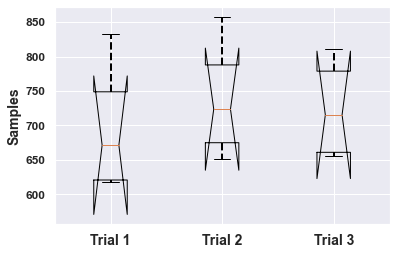

In [87]:
l_d = [ii for ii in range(0,len(d)) if ii % 5 == 2]

d1 = []
d2 = []
d3 = []

for n in l_d:
    t1 = d[n]
    d1.append(t1)
    t2 = d[n+1]
    d2.append(t2)
    t3 = d[n+2]
    d3.append(t3)

labels = ['Trial 1','Trial 2','Trial 3']
plt.boxplot([d1, d2, d3], notch=True, labels=labels, whiskerprops=dict(linestyle='--',linewidth=2.0))
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Samples', fontweight='bold', fontsize=14)

Text(0, 0.5, 'Samples')

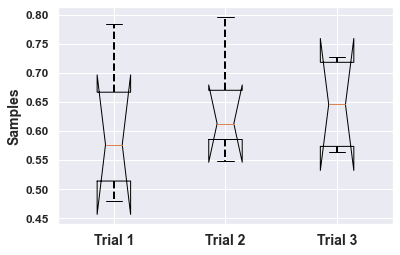

In [88]:
tam1 = []
tam2 = []
tam3 = []

for n in l_d:
    t1 = tam_results[n]
    tam1.append(t1)
    t2 = tam_results[n+1]
    tam2.append(t2)
    t3 = tam_results[n+2]
    tam3.append(t3)

labels = ['Trial 1','Trial 2','Trial 3']
plt.boxplot([tam1, tam2, tam3], notch=True, labels=labels, whiskerprops=dict(linestyle='--',linewidth=2.0))
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=12)
plt.ylabel('Samples', fontweight='bold', fontsize=14)